***
# Specwizard
***

## Description
***

In this notebook we will show an example of the tools an utilities of specwizard. The notebook will go throught different parts:

* Import the necesary modules and functions
* Read necesary data: <br>
  * Read parameter file <br>
  * Read Line of sight file (LOS) <br>
  * Read Simulation data <br>
  * Conversion Factors <br>
  * Read Ionization tables <br>
* Conversion from Simulation to Physical Units
* Project the data to the pixel size


## Loading all the necesary modules
***

In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import physical_data as const
import reading_data_for_los as RD
import read_ionizationtables as RIT
from read_params_yaml import read_params_yaml
from projectdataf import project_data
from conversion_to_physical import conversion_to_physical as C2P

This is saying the use snapshot file is True


## Reading the data
***

First we will use the function **read_params_yaml**

In [2]:
parameters = read_params_yaml('test.yml')

In [4]:
print("Simulation data directory: %s" %parameters.datadir)
print("Would we use the H1 ion?: %s"  %parameters.doH1)
print("Would we use the He2 ion?: %s" %parameters.doHe2)

Simulation data directory: /home/andres/
Would we use the H1 ion?: True
Would we use the He2 ion?: False


This class will be used for several functions in the code 
***


Important parameters of simulations ( such as boxsize or number of gas particles) are usually stored in a  **heather** in the file. For accessing them, we will use the function **read_header** from the module **reading_data_for_los** that we imported as **RD**. As input will take the parameter class.


In [5]:
simdata = RD.read_header(parameters)

For an output we will have an object that contains the simulation header as attributes. For example: 

In [6]:
print("This is the Boxsize: %f" % simdata.BoxSize)
print("This is the expansion factor (a): %f" % simdata.ExpansionFactor)

This is the Boxsize: 67.770000
This is the expansion factor (a): 0.990133


***
Next we will load the simulation data. In this case we will read from a file that contains the information from individual lines of sight (LOS). As we can see in the parameter file 'test.yml'

In [7]:
parameters.use_los_file

True

For loading the data we will use the function **reading_data_for_los** from the module **reading_data_for_los** that we imported as RD. As input it takes the class parameters, and when we have the option *parameters.use_los_file= True*  we also have to provide the Line of sight number (LOS_Number), that we will read from the file (i,e 0->First line of sight in the file)

In [8]:
LOS_number = 0
los = RD.read_particle_data_from_los(parameters,LOS_number)  

LOS0/PartType0/Positions


As an output we will haven a object called los, where we can retreive all the needed information from the LOS. For example, we can use some attributes to make some important plots:

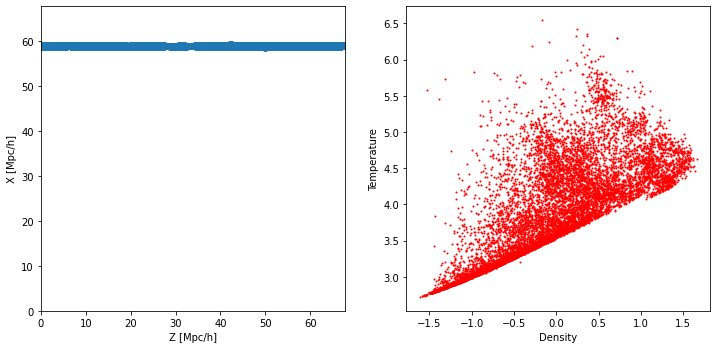

In [9]:
fig, axs = plt.subplots(1,2,figsize=(12,12))
xval = los.Position[:,2]
yval = los.Position[:,0]
axs[0].scatter(xval,yval)
axs[0].set_xlim(0,simdata.BoxSize)
axs[0].set_ylim(0,simdata.BoxSize)
axs[0].set_xlabel("Z [Mpc/h]")
axs[0].set_ylabel("X [Mpc/h]")
axs[0].set_box_aspect(1)

xval = np.log10(los.ParticleDensity)
yval = np.log10(los.ParticleTemperature)

axs[1].scatter(xval,yval,s=1,c='r')
axs[1].set_xlabel("Density")
axs[1].set_ylabel("Temperature")
axs[1].set_box_aspect(1)


***
As we can see in the plot above, the units are not in physicial units, in order to do a conversion of units we use would first load some of the conversion factors from the simulation using the function **units_and_factors_for_los** from the module **reading_data_for_los** that we loaded as RD.  As input it takes the parameters object.

In [10]:
convert = RD.units_and_factors_for_los(parameters)


The output is an object that contains conversion factors and constants:

In [11]:
print("centimiters in a Mpc: %f" % convert.cm_per_mpc)

centimiters in a Mpc: 3085677999999999983747072.000000


Using that object, and the constants loaded as **const**, we can use the function **conversion_to_physical** imported as C2P to update our los data into physical and cgs units. 

In [12]:
los = C2P(los,simdata,convert,const)

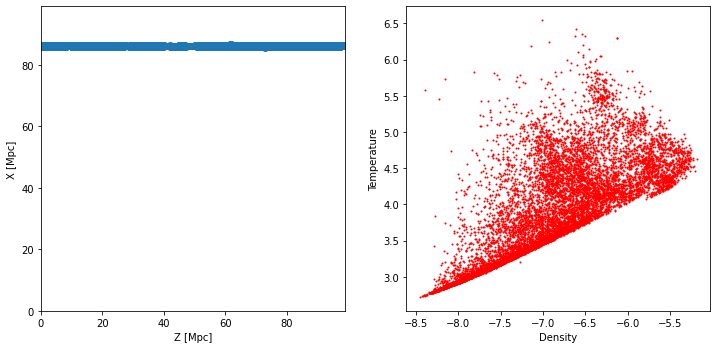

In [13]:
fig, axs = plt.subplots(1,2,figsize=(12,12))
xval = los.Position[:,2]
yval = los.Position[:,0]
axs[0].scatter(xval,yval)
axs[0].set_xlim(0,los.Position[:,2].max())
axs[0].set_ylim(0,los.Position[:,2].max())
axs[0].set_xlabel("Z [Mpc]")
axs[0].set_ylabel("X [Mpc]")
axs[0].set_box_aspect(1)

xval = np.log10(los.ParticleDensity)
yval = np.log10(los.ParticleTemperature)

axs[1].scatter(xval,yval,s=1,c='r')
axs[1].set_xlabel("Density")
axs[1].set_ylabel("Temperature")
axs[1].set_box_aspect(1)

***
As shown before, one of the useful aspects of using objects, is that we can update and add new attributes to the object, for example here we will add some new attributes to the simdata object

In [14]:
acurrent = simdata.ExpansionFactor
zcurrent = simdata.Redshift

simdata.CurrentHubbleCt = 100. * simdata.HubbleParam *  np.sqrt(1. + simdata.Omega0*(1./acurrent-1.) + simdata.OmegaLambda* (acurrent**2-1.)) /acurrent
simdata.boxkms = simdata.BoxSize / simdata.HubbleParam * acurrent * simdata.CurrentHubbleCt

simdata.vpixsizekms = 1
simdata.nveloc = int(simdata.boxkms / simdata.vpixsizekms) + 1

*** 
Finaly we will use the **read_iontables** function from the read_ionizationtables module that we loaded as RIT. With the parameters object as input.

In [15]:
ionpar = RIT.read_iontables(parameters)

h1 Ionization table loaded


As output will return an object that will contain all the necesary ion information to do the interpolation in the next function

***
### Projecting the Data

Here we will use all the data that we loaded and shaped, to produce ionization balance by interpolating the density, temperature, and redshfit

In [16]:
los,tf = project_data(los,simdata,parameters,ionpar)

It took 3.891338 seconds


In [17]:
los.n_ion

1

The function will return an updated los object that contains new attributes such as:
* rho_tot:
* rho_ion:
* temp_tot:
* temp_ion:
* veloc_tot:
* veloc_ion:
* n_ion:
* met_tot

Which are in velocity space with the velocity pixel size. As shown in the plots below.

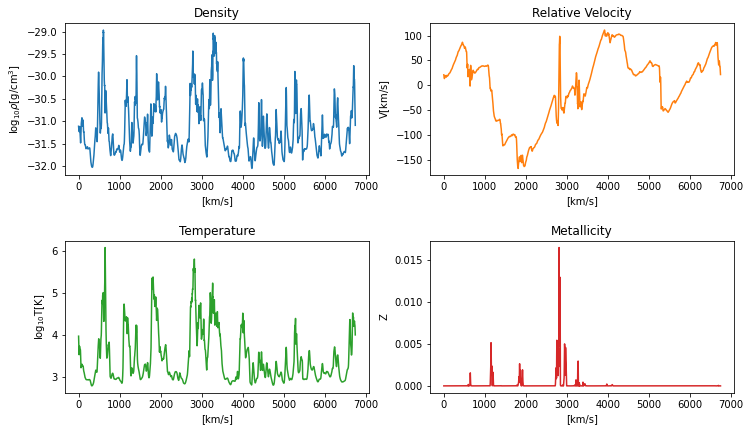

In [18]:
fig, axs = plt.subplots(2, 2,figsize=(12,12))
axs[0, 0].plot(np.log10(los.rho_tot))
axs[0, 0].set_title('Density')
axs[0, 0].set_box_aspect(1/2)


axs[0, 1].plot(los.veloc_tot, 'tab:orange')
axs[0, 1].set_title('Relative Velocity')
axs[0, 1].set_box_aspect(1/2)

axs[1, 0].plot(np.log10(los.temp_tot), 'tab:green')
axs[1, 0].set_title('Temperature')
axs[1, 0].set_box_aspect(1/2)

axs[1, 1].plot(los.met_tot, 'tab:red')
axs[1, 1].set_title('Metallicity')
axs[1, 1].set_box_aspect(1/2)

ylabels = [r"$\log_{10} \rho \mathrm{[g/cm^3]}$", "$\mathrm{V[km/s]}$","$\log_{10} \mathrm{T[K]}$","$\mathrm{Z}$"]
for i,ax in enumerate(axs.flat):
    ax.set(xlabel='[km/s]', ylabel=ylabels[i])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=-0.5)